# Get data and missing values

In [44]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")

print("train shape", train.shape)
print("test shape", test.shape)
print("submission shape", submission.shape) 
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Missing data categories: ")
for column, count in missing.items():
    print(column, count, f"{count / len(train) * 100:.1f}%")

train shape (8693, 14)
test shape (4277, 13)
submission shape (4277, 2)
Missing data categories: 
CryoSleep 217 2.5%
ShoppingMall 208 2.4%
VIP 203 2.3%
HomePlanet 201 2.3%
Name 200 2.3%
Cabin 199 2.3%
VRDeck 188 2.2%
FoodCourt 183 2.1%
Spa 183 2.1%
Destination 182 2.1%
RoomService 181 2.1%
Age 179 2.1%


# Remove rows with missing data

In [22]:
# Drop any rows that have missing values
train_clean = train.dropna()

# Print shapes to see how many rows we kept
print("Original training data shape:", train.shape)
print("Clean training data shape:", train_clean.shape)
print(f"Removed {train.shape[0] - train_clean.shape[0]} rows ({(train.shape[0] - train_clean.shape[0])/train.shape[0]*100:.1f}% of data)")

# Display data types and remove boolean columns (except Transported)
print("\nColumn data types:")
for col in train_clean.columns:
    print(f"{col}: {train_clean[col].dtype}")

# Keep only non-boolean columns and the Transported target column
non_bool_cols = [col for col in train_clean.columns if train_clean[col].dtype != 'bool' or col == 'Transported']
train_clean = train_clean[non_bool_cols]

print("\nColumns kept after removing extra booleans:")
print(train_clean.columns.tolist())

# Save the clean dataset to a new CSV file
train_clean.to_csv("train_clean.csv", index=False)
print("\nSaved clean training data to 'train_clean.csv'")

Original training data shape: (8693, 14)
Clean training data shape: (6606, 14)
Removed 2087 rows (24.0% of data)

Column data types:
PassengerId: object
HomePlanet: object
CryoSleep: object
Cabin: object
Destination: object
Age: float64
VIP: object
RoomService: float64
FoodCourt: float64
ShoppingMall: float64
Spa: float64
VRDeck: float64
Name: object
Transported: bool

Columns kept after removing extra booleans:
['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']

Saved clean training data to 'train_clean.csv'


# Find any correlations the data has

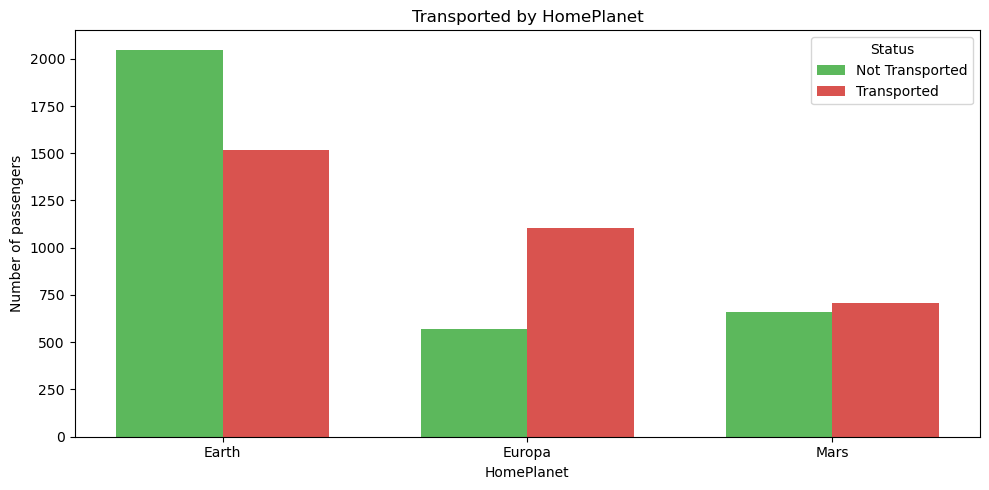

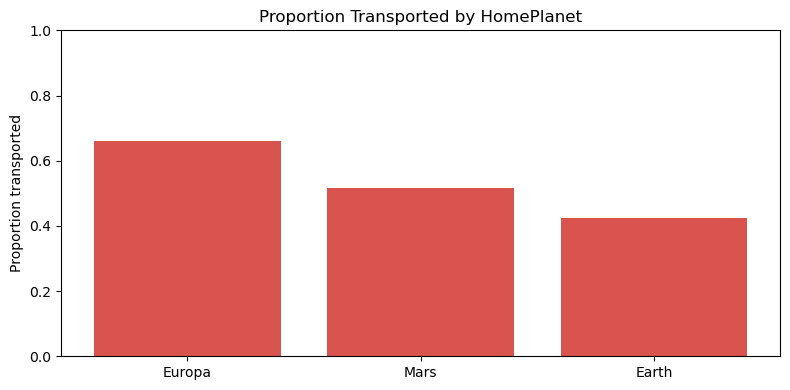

            total  transported_count  transported_pct
HomePlanet                                           
Europa       1673               1104         0.659892
Mars         1367                705         0.515728
Earth        3566               1518         0.425687


In [20]:
# Transported by HomePlanet
# prepare dataframe using clean data
df = train_clean.copy()

# Get counts by HomePlanet and Transported status
counts = df.groupby(['HomePlanet', 'Transported']).size().reset_index(name='count')
counts_pivot = counts.pivot(index='HomePlanet', columns='Transported', values='count')
counts_pivot = counts_pivot.reindex(sorted(counts_pivot.index))

# plot grouped bar chart
plt.figure(figsize=(10,5))
x = np.arange(len(counts_pivot.index))
width = 0.35  # width of the bars

plt.bar(x - width/2, counts_pivot[False], width, label='Not Transported', color='#5cb85c')
plt.bar(x + width/2, counts_pivot[True], width, label='Transported', color='#d9534f')

plt.title('Transported by HomePlanet')
plt.ylabel('Number of passengers')
plt.xlabel('HomePlanet')
plt.xticks(x, counts_pivot.index)
plt.legend(title='Status')
plt.tight_layout()
plt.show()

# proportion transported by planet
plt.figure(figsize=(8,4))
transported_pct = df.groupby('HomePlanet')['Transported'].mean().sort_values(ascending=False)
x = transported_pct.index
y = transported_pct.values
plt.bar(x, y, color='#d9534f')
plt.ylabel('Proportion transported')
plt.ylim(0,1)
plt.title('Proportion Transported by HomePlanet')
plt.tight_layout()
plt.show()

# also print a small summary table
summary = df.groupby('HomePlanet').agg(total=('Transported','size'), transported_count=('Transported', lambda x: x.sum()))
summary['transported_pct'] = summary['transported_count'] / summary['total']
print(summary.sort_values('transported_pct', ascending=False))

C:\Users\hhans\AppData\Local\Temp\ipykernel_19648\791679977.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_counts = df.groupby(['AgeGroup', 'Transported']).size().reset_index(name='count')


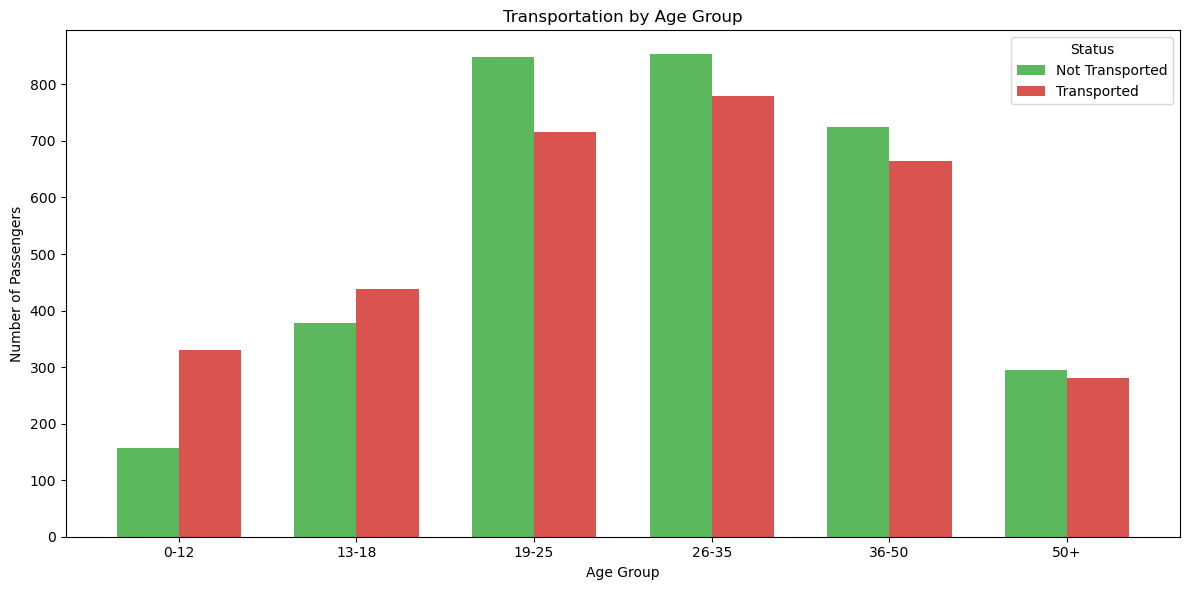

C:\Users\hhans\AppData\Local\Temp\ipykernel_19648\791679977.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  transported_by_age = df.groupby('AgeGroup')['Transported'].mean().sort_values(ascending=False)


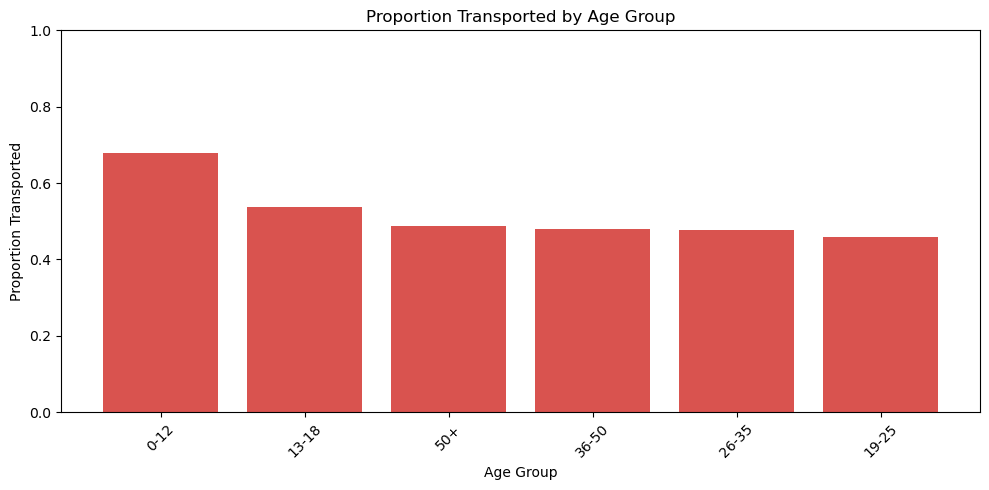


Summary by Age Group:
          total  transported_count  avg_age  transported_pct
AgeGroup                                                    
0-12        488                331     5.74            67.83
13-18       817                439    15.94            53.73
50+         575                280    58.30            48.70
36-50      1389                665    41.84            47.88
26-35      1633                780    30.00            47.76
19-25      1564                716    22.01            45.78


C:\Users\hhans\AppData\Local\Temp\ipykernel_19648\791679977.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby('AgeGroup').agg(


In [35]:
# Age analysis
df = train_clean.copy()

# Create age groups for better visualization
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 25, 35, 50, 100], 
                       labels=['0-12', '13-18', '19-25', '26-35', '36-50', '50+'])

# Calculate counts by age group and transport status
age_counts = df.groupby(['AgeGroup', 'Transported']).size().reset_index(name='count')
age_pivot = age_counts.pivot(index='AgeGroup', columns='Transported', values='count')

# Plot grouped bar chart
plt.figure(figsize=(12,6))
x = np.arange(len(age_pivot.index))
width = 0.35

plt.bar(x - width/2, age_pivot[False], width, label='Not Transported', color='#5cb85c')
plt.bar(x + width/2, age_pivot[True], width, label='Transported', color='#d9534f')

plt.title('Transportation by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Passengers')
plt.xticks(x, age_pivot.index)
plt.legend(title='Status')
plt.tight_layout()
plt.show()

# Calculate and plot proportion transported by age group
plt.figure(figsize=(10,5))
transported_by_age = df.groupby('AgeGroup')['Transported'].mean().sort_values(ascending=False)
plt.bar(transported_by_age.index, transported_by_age.values, color='#d9534f')
plt.title('Proportion Transported by Age Group')
plt.ylabel('Proportion Transported')
plt.xlabel('Age Group')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics
summary = df.groupby('AgeGroup').agg(
    total=('Transported', 'size'),
    transported_count=('Transported', 'sum'),
    avg_age=('Age', 'mean')
).round(2)
summary['transported_pct'] = (summary['transported_count'] / summary['total'] * 100).round(2)
print("\nSummary by Age Group:")
print(summary.sort_values('transported_pct', ascending=False))

C:\Users\hhans\AppData\Local\Temp\ipykernel_19648\3746564039.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Blues')
C:\Users\hhans\AppData\Local\Temp\ipykernel_19648\3746564039.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spending_props = df.groupby(f'{column}_Group')['Transported'].mean().sort_index()
C:\Users\hhans\AppData\Local\Temp\ipykernel_19648\3746564039.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

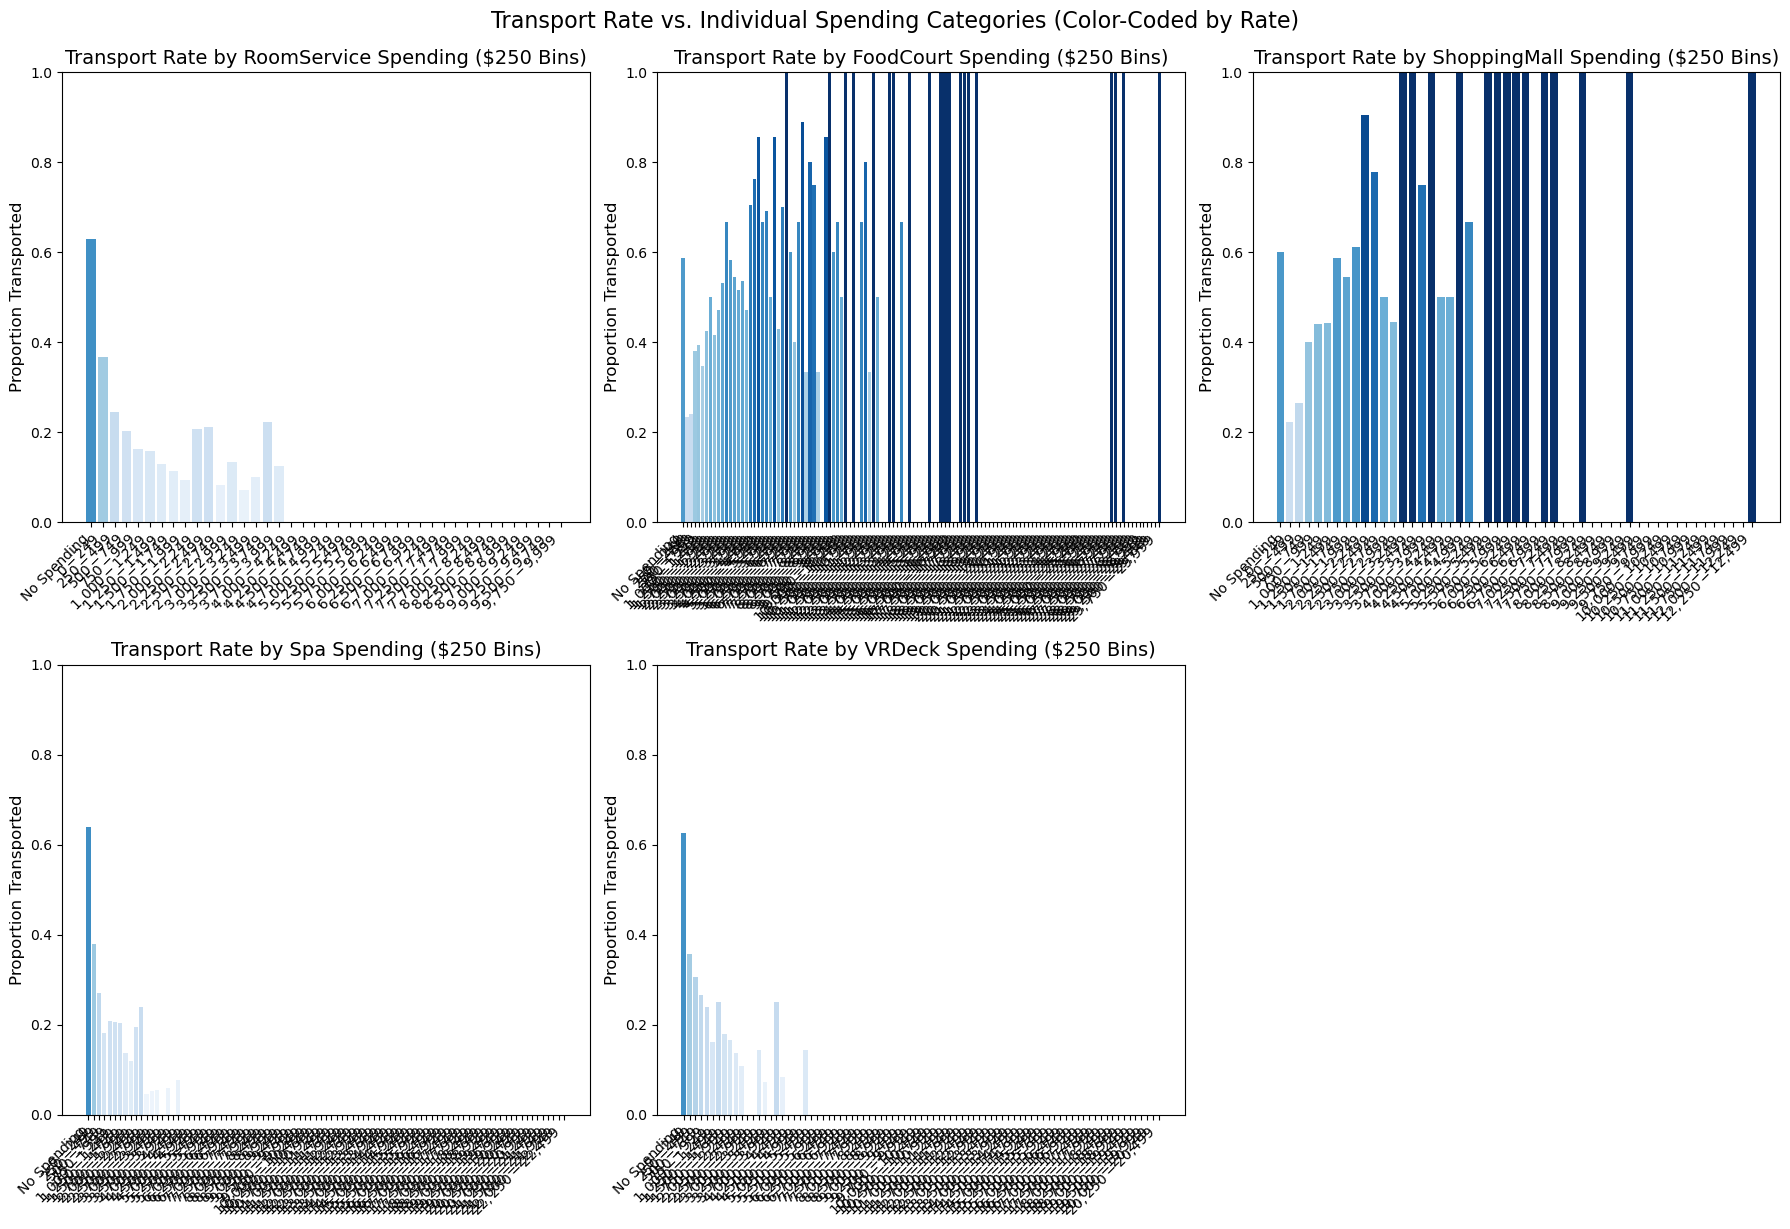

# Hot-one encoding for non-numerical features

In [32]:
# Start with our clean dataset
df = train_clean.copy()

# Display data types of each column
print("Data types of each column:")
print(df.dtypes)
print("\n")

# Identify non-numeric columns (excluding the target variable 'Transported')
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
non_numeric_cols = [col for col in non_numeric_cols if col not in ['Transported', 'PassengerId', 'Name', 'Cabin', 'VIP', 'CryoSleep']]

print("Columns to encode:", non_numeric_cols)
print("\n")

# Create one-hot encoded features
df_encoded = pd.get_dummies(df, columns=non_numeric_cols, prefix_sep='_')


# Show the new columns created
print("New columns after one-hot encoding:")
new_cols = [col for col in df_encoded.columns if any(f"{prefix}_" in col for prefix in non_numeric_cols)]
for col in new_cols:
    print(col)
print(f"\nTotal new encoded columns: {len(new_cols)}")

# Show shape comparison
print(f"\nOriginal shape: {df.shape}")
print(f"Encoded shape: {df_encoded.shape}")

# Save the encoded dataset
df_encoded.to_csv("train_encoded.csv", index=False)
print("\nSaved encoded dataset to 'train_encoded.csv'")

Data types of each column:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


Columns to encode: ['HomePlanet', 'Destination']


New columns after one-hot encoding:
HomePlanet_Earth
HomePlanet_Europa
HomePlanet_Mars
Destination_55 Cancri e
Destination_PSO J318.5-22
Destination_TRAPPIST-1e

Total new encoded columns: 6

Original shape: (6606, 14)
Encoded shape: (6606, 18)

Saved encoded dataset to 'train_encoded.csv'


# Training the model